In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from scipy import optimize, interpolate
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from scipy.optimize import basinhopping
import warnings

In [2]:
# /data/df.pickleの読み込み
df = pd.read_pickle('../data/df.pickle')

df = df.dropna()

# データの分割
df_p1 = df[(df['started_at'] >= '2020-03-01') & (df['started_at'] < '2020-06-01')].dropna()
df_p2 = df[(df['started_at'] >= '2020-06-01') & (df['started_at'] < '2020-11-01')].dropna()
df_p3 = df[(df['started_at'] >= '2020-12-01') & (df['started_at'] < '2021-03-01')].dropna()
df_p4 = df[(df['started_at'] >= '2021-03-01') & (df['started_at'] < '2023-10-01')].dropna()
df_p4_1 = df[(df['started_at'] >= '2021-03-01') & (df['started_at'] < '2022-01-01')].dropna()
df_p4_2 = df[(df['started_at'] >= '2022-01-01') & (df['started_at'] < '2023-10-01')].dropna()
df_left = pd.concat([df_p1, df_p2, df_p3, df_p4_1], axis=0)
df_right = pd.concat([df_p4_2], axis=0)



In [3]:
def return_nm(df):
    df['started_at'] = pd.to_datetime(df['started_at'])
    df['ended_at'] = pd.to_datetime(df['ended_at'])
    # started_atで昇順にソート
    df = df.sort_values(by='started_at')
    current_timestamp = df['started_at'].min()
    end_timestamp = df["started_at"].max()
    interval = timedelta(days=1)

    node_list = []
    edge_list = []
    timestamp = []

    while current_timestamp <= end_timestamp:
        timestamp.append(current_timestamp)
        next_timestamp = current_timestamp + interval
        df_tmp = df[(df['started_at'] >= current_timestamp) & (df['started_at'] < next_timestamp)]

        # node_listにはユニークなstart_station_idを追加
        node_list.append(len(df_tmp['start_station_id'].unique()))

        # edge_listにはdf_tmpの行数を追加
        edge_list.append(len(df_tmp))

        current_timestamp = next_timestamp

    # node_listとedge_listで0の値を削除
    node_list = np.array(node_list)
    edge_list = np.array(edge_list)
    timestamp = np.array(timestamp)
    active_node_list = node_list[node_list != 0]
    edge_list = edge_list[edge_list != 0]
    timestamp = timestamp[:len(node_list)]
    
    return active_node_list, edge_list, timestamp

In [4]:
node_left, edge_left, timestamp_left = return_nm(df_left)

In [5]:
# node_leftとedge_leftを組みにしてdf_leftを作成
left = pd.DataFrame({'node': node_left, 'edge': edge_left})
# df_leftのnodeを昇順にして並び替え
left = left.sort_values(by='node')
# インデックスを振り直す
left = left.reset_index(drop=True)
left.head()

,node,edge
0,106,190
1,136,221
2,173,312
3,215,368
4,217,494


In [6]:
# 正規化する
left["node_norm"] = left["node"] - left["node"].min() + 2
left["edge_norm"] = left["edge"] - left["edge"].min() + 1

# 一番最初の行を削除
left = left.drop(0)

# インデックスを振り直す
left = left.reset_index(drop=True)


In [66]:
def f(x, Np):
    kappa = ((8 * x[0]) / (Np**2 - Np))
    a = (1 - (kappa / 2))**Np
    b = 1 - a
    c = -(2 / (kappa * Np))*b
    d = 1 + c
    res = Np * d
    return res

In [8]:
x = left["edge_norm"]
y = left["node_norm"]

In [56]:
left.to_csv('../data/df_left.csv', index=False)

In [68]:
# 残差
def residual_f(x, N, M):
    residual = N - f(x, M)
    return residual

In [69]:
# 目的関数
def f_uniform_2(x, N, M):
    return np.sum(residual_f(x, M, N)**2)

In [61]:
# 最適化

params, _ = optimize.curve_fit(f, x, y, p0=[14])
print("params", params[0])

params 4095.2135264380536


In [70]:
# leastsqを使用
initial_guess = [600]
params, _ = optimize.leastsq(residual_f, initial_guess, args=(x, y))
print("params", params[0])

params 576.0334895620256


In [49]:
# least_squaresを使用
res = optimize.least_squares(residual_f, initial_guess, args=(x, y))
print("params", res.x[0])

params 576.0198575051828


In [48]:
# 残差平方和を最小化
res = optimize.minimize(f_uniform_2, initial_guess, args=(x, y))
print("params", res.x[0])

params 208.1489307232768


In [71]:
# 元の関数に代入する
Np_norm_hat = res.x[0]
Np_norm_hat = round(Np_norm_hat, 2)
print("+------------------+")
kappa_norm_estimated = []
for i in range(len(x)):
    kappa_norm_estimated.append( ((8 * x[i]) / (Np_norm_hat**2 - Np_norm_hat)) )

# Eq8, 9
N_norm = []
M_norm = []
for i in range(len(kappa_norm_estimated)):
    N_norm.append( f(x, Np_norm_hat) )
    M_norm.append( (kappa_norm_estimated[i] * Np_norm_hat * (Np_norm_hat - 1)) / 8 )

print("|      DONE        |")
print("+------------------+")
print("| Np: ", Np_norm_hat)
print("| N max: ", left["node_norm"].max())
print("| kappa: ", kappa_norm_estimated[0])
print("| N: ", N_norm[0])
print("| M: ", M_norm[0])
print("+------------------+")

+------------------+
|      DONE        |
+------------------+
| Np:  576.02
| N max:  514
| kappa:  0.0007728931391629808
| N:  59.51848222608584
| M:  32.0
+------------------+


+------------------+
|      DONE        |
+------------------+
| Np:  576.02
| N max:  514
| kappa:  0.0007728931391629808
| N:  59.51848222608584
| M:  32.0
+------------------+


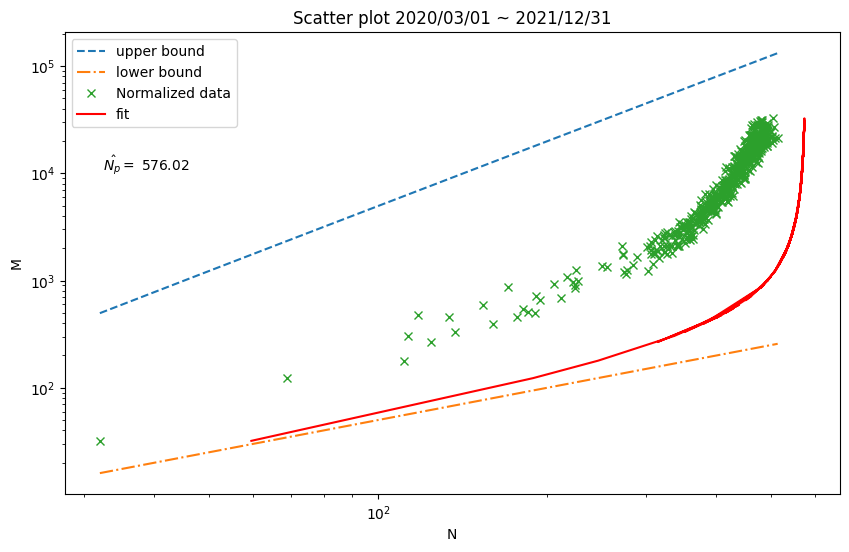

In [75]:
nn = len(left["node_norm"]) - 1
xmin = min(left["node_norm"])
xmax = max(left["node_norm"])
p = np.linspace(xmin, xmax, nn)
upper_bound = (p**2-p)/2
lower_bound = p/2

Np_norm_hat = round(Np_norm_hat, 2)
print("+------------------+")
kappa_norm_estimated = [((8 * x[i]) / (Np_norm_hat * (Np_norm_hat - 1))) for i in range(len(x))]

# Eq8, 9
N_norm = []
M_norm = []
for i in range(len(kappa_norm_estimated)):
    N_norm.append( Np_norm_hat * (1 - (2 / (kappa_norm_estimated[i]*Np_norm_hat))*(1-(1-(kappa_norm_estimated[i]/2))**Np_norm_hat)) )
    M_norm.append( (kappa_norm_estimated[i] * Np_norm_hat * (Np_norm_hat - 1)) / 8 )

print("|      DONE        |")
print("+------------------+")
print("| Np: ", Np_norm_hat)
print("| N max: ", max(y))
print("| kappa: ", kappa_norm_estimated[0])
print("| N: ", N_norm[0])
print("| M: ", M_norm[0])
print("+------------------+")



plt.figure(figsize=(10, 6))
plt.title("Scatter plot 2020/03/01 ~ 2021/12/31")
plt.plot(p, upper_bound, '--', label="upper bound")
plt.plot(p, lower_bound, '-.', label="lower bound")
plt.plot(y, x, "x", label='Normalized data')
plt.plot(N_norm,M_norm,label='fit', color='red')
Np_norm_hat = round(Np_norm_hat, 2)
plt.text(0.05, 0.70, r'$\hat{N_{p}}=$ ' + str(Np_norm_hat), transform=plt.gca().transAxes)
plt.xlabel('N')
plt.ylabel('M')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='best')
plt.show()